In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [3]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

from torch.utils.data import DataLoader

# Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}


Training Images:


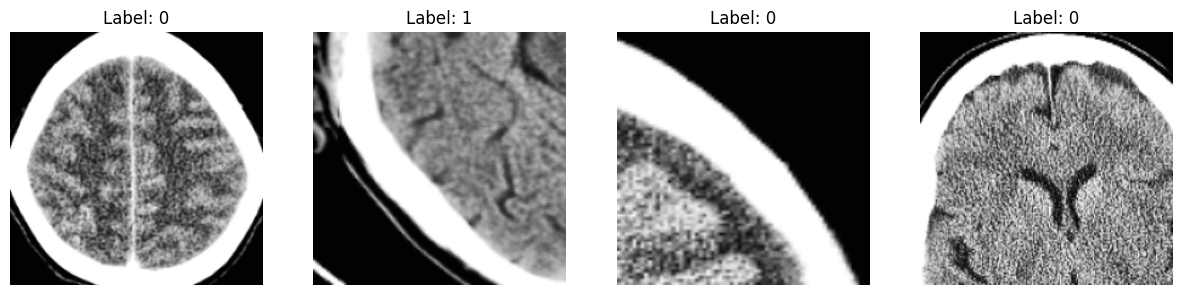

Validation Images:


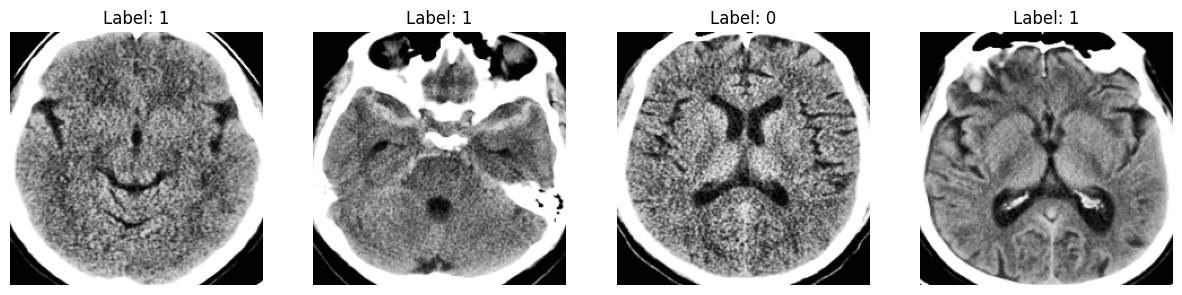

In [5]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction Resnext101


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnext101_64x4d(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model = model.to(device)


cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Removing layer4

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

## finding the output of last leyer3

torch.Size([1, 1024, 14, 14])


In [9]:
children = list(model.children())
truncated_features = nn.Sequential(*children[:-3])
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = truncated_features(sample_input)
# Compute the in_features for the classifier
in_features = output.numel() // output.shape[0]
# Define the new classifier
classifier = nn.Sequential(
    nn.Linear(in_features, 2),
)

In [10]:
from collections import OrderedDict


# Combine the truncated features and the classifier into a new model
model = nn.Sequential(OrderedDict([
    ("features", truncated_features),
    ("flatten", nn.Flatten()),
    ("classifier", classifier)
]))

model.to(device)

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
bestmodel = {
    'model': model,
    'state_dict': model.state_dict(),
}
torch.save(bestmodel, 'Resnext_Truncate.pth')


In [26]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                        Param #
Sequential                                    --
├─Sequential: 1-1                             --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (109,568)
│    │    └─Bottleneck: 3-2                   (141,824)
│    │    └─Bottleneck: 3-3                   (141,824)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (565,248)
│    │    └─Bottleneck: 3-5                   (564,224)
│    │    └─Bottleneck: 3-6                   (564,224)
│    │    └─Bottleneck: 3-7                   (564,224)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (2,252,800)
│    │    └─Bottleneck: 3-9                   (

In [27]:
for name, param in model.named_parameters():
    # print(name, param.requires_grad)
    if param.requires_grad:
        print(name)


classifier.0.weight
classifier.0.bias


In [28]:
# for param in model.parameters():
#     param.requires_grad = True


In [29]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print("output : ",outputs)
                    # print('*'*20)
                    # print('grad_fn: ',outputs.grad_fn)
                    # print('*'*20)
                    # print(labels)
                    loss = criterion(outputs, labels)
                        
                _, preds = torch.max(outputs.detach(), 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    # print(loss.grad_fn)
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


In [30]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------
train Loss: 42.3587 Acc: 0.5882


  5%|▌         | 1/20 [00:52<16:44, 52.88s/it]

valid Loss: 5.3060 Acc: 0.7003

Epoch 2/20
----------
train Loss: 15.1637 Acc: 0.6277


 10%|█         | 2/20 [01:44<15:36, 52.01s/it]

valid Loss: 9.3491 Acc: 0.6012

Epoch 3/20
----------
train Loss: 19.6983 Acc: 0.6102


 15%|█▌        | 3/20 [02:34<14:28, 51.06s/it]

valid Loss: 6.7949 Acc: 0.7355

Epoch 4/20
----------
train Loss: 15.8753 Acc: 0.6401


 20%|██        | 4/20 [03:24<13:29, 50.58s/it]

valid Loss: 13.3077 Acc: 0.6977

Epoch 5/20
----------
train Loss: 13.3069 Acc: 0.6663


 25%|██▌       | 5/20 [04:13<12:35, 50.34s/it]

valid Loss: 27.3271 Acc: 0.6289

Epoch 6/20
----------
train Loss: 7.7637 Acc: 0.7081


 30%|███       | 6/20 [05:03<11:42, 50.17s/it]

valid Loss: 6.0935 Acc: 0.7607

Epoch 7/20
----------
train Loss: 6.0987 Acc: 0.7287


 35%|███▌      | 7/20 [05:53<10:49, 49.99s/it]

valid Loss: 5.9654 Acc: 0.7607

Epoch 8/20
----------
train Loss: 6.1621 Acc: 0.7167


 40%|████      | 8/20 [06:43<09:58, 49.90s/it]

valid Loss: 7.6671 Acc: 0.7439

Epoch 9/20
----------
train Loss: 5.6369 Acc: 0.7341


 45%|████▌     | 9/20 [07:32<09:07, 49.76s/it]

valid Loss: 4.7480 Acc: 0.7548

Epoch 10/20
----------
train Loss: 5.6314 Acc: 0.7167


 50%|█████     | 10/20 [08:22<08:17, 49.77s/it]

valid Loss: 6.2524 Acc: 0.7473

Epoch 11/20
----------
train Loss: 4.7308 Acc: 0.7346


 55%|█████▌    | 11/20 [09:11<07:27, 49.70s/it]

valid Loss: 4.5793 Acc: 0.7498

Epoch 12/20
----------
train Loss: 4.7378 Acc: 0.7304


 60%|██████    | 12/20 [10:01<06:36, 49.60s/it]

valid Loss: 4.9446 Acc: 0.7624

Epoch 13/20
----------
train Loss: 4.8659 Acc: 0.7339


 65%|██████▌   | 13/20 [10:50<05:46, 49.54s/it]

valid Loss: 4.6810 Acc: 0.7641

Epoch 14/20
----------
train Loss: 4.9453 Acc: 0.7257


 70%|███████   | 14/20 [11:40<04:57, 49.57s/it]

valid Loss: 4.8578 Acc: 0.7649

Epoch 15/20
----------
train Loss: 4.7699 Acc: 0.7344


 75%|███████▌  | 15/20 [12:29<04:07, 49.58s/it]

valid Loss: 4.4688 Acc: 0.7649

Epoch 16/20
----------
train Loss: 4.9311 Acc: 0.7285


 80%|████████  | 16/20 [13:19<03:18, 49.62s/it]

valid Loss: 4.9454 Acc: 0.7615

Epoch 17/20
----------
train Loss: 4.8807 Acc: 0.7234


 85%|████████▌ | 17/20 [14:10<02:29, 49.98s/it]

valid Loss: 4.8183 Acc: 0.7615

Epoch 18/20
----------
train Loss: 4.8272 Acc: 0.7218


 90%|█████████ | 18/20 [15:01<01:40, 50.28s/it]

valid Loss: 4.5325 Acc: 0.7657

Epoch 19/20
----------
train Loss: 4.9946 Acc: 0.7218


 95%|█████████▌| 19/20 [15:51<00:50, 50.25s/it]

valid Loss: 4.6767 Acc: 0.7615

Epoch 20/20
----------
train Loss: 4.6798 Acc: 0.7308


100%|██████████| 20/20 [16:41<00:00, 50.08s/it]

valid Loss: 5.0048 Acc: 0.7565

Training complete in 16m 42s
Best valid accuracy: 0.765743


In [31]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[566 117]
 [162 346]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       683
           1       0.75      0.68      0.71       508

    accuracy                           0.77      1191
   macro avg       0.76      0.75      0.76      1191
weighted avg       0.76      0.77      0.76      1191



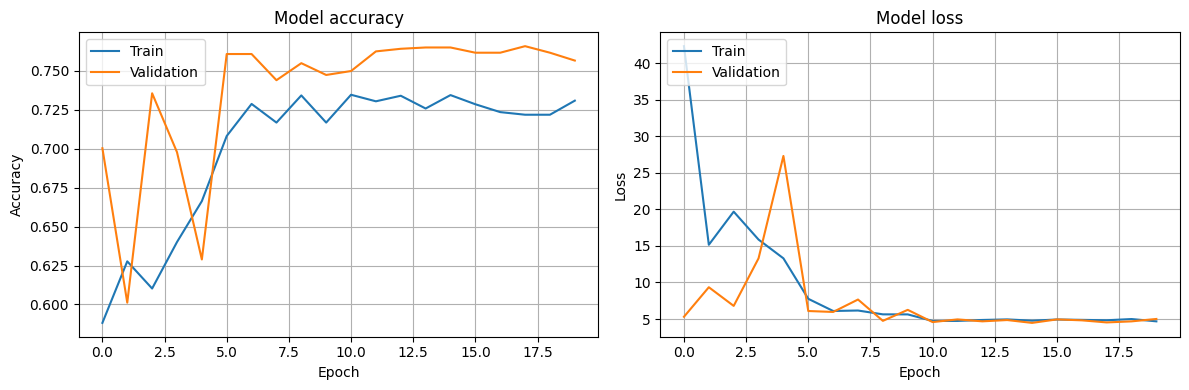

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
model.state_dict()